In [ ]:
%pip install xgboost
%pip install tensorflow

In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
sys.path.append("../utils")

from utils import load_csv
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
symbols = ["fpt", "hpg", "vnm"]
dfs = {s: load_csv(f"../../data/features/{s}_features.csv") for s in symbols}
feature_cols = [
    "open", "high", "low", "close", "volume",
    "return", "ma5", "ma10", "ma20", "volatility_5", "vol_change"
]

2025-05-26 16:31:16,419 - INFO - ✅ Load CSV thành công: ../../data/features/fpt_features.csv | shape = (4562, 11)


2025-05-26 16:31:16,430 - INFO - ✅ Load CSV thành công: ../../data/features/hpg_features.csv | shape = (4333, 11)
2025-05-26 16:31:16,452 - INFO - ✅ Load CSV thành công: ../../data/features/vnm_features.csv | shape = (4788, 11)


In [21]:
df = load_csv("../../data/features/hpg_features.csv")

2025-05-26 16:31:17,412 - INFO - ✅ Load CSV thành công: ../../data/features/hpg_features.csv | shape = (4333, 11)


In [22]:
df.index = df.date
df.drop('date',axis=1,inplace=True)
df

,open,high,low,close,volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
date,,,,,,,,,,
2007-11-15,2.46,2.46,2.06,2.40,1306330,2.041836,2.172,2.102,2.063333,1.928333
2007-11-16,2.29,2.29,2.29,2.29,248510,2.014262,2.130,2.073,2.039333,1.912667
2007-11-19,2.17,2.17,2.17,2.17,120480,1.996958,2.108,2.056,2.017333,1.901333
2007-11-20,2.08,2.08,2.08,2.08,58710,1.987731,2.088,2.046,1.996000,1.893333
2007-11-21,1.98,2.16,1.98,2.16,728080,1.968590,2.060,2.027,1.970667,1.883000
...,...,...,...,...,...,...,...,...,...,...
2025-04-01,26.80,27.05,26.75,27.00,14018400,24.887387,24.280,24.515,24.776667,25.231667
2025-04-02,27.15,27.40,27.10,27.25,16785400,24.616504,23.380,24.340,24.666667,25.178333
2025-04-03,25.80,26.45,25.35,25.35,80695800,24.532106,23.170,24.350,24.690000,25.191667


In [23]:
df1 = df.reset_index()['close']
df1.head()

0    2.40
1    2.29
2    2.17
3    2.08
4    2.16
Name: close, dtype: float64

In [24]:
# chuẩn hoá dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.04385518],
       [0.04105048],
       [0.03799082],
       ...,
       [0.62901581],
       [0.60989291],
       [0.56654768]])

In [25]:
split_index = int(len(df1)*0.7)
train_data, test_data = df1[:split_index], df1[split_index:]
train_data

array([[0.04385518],
       [0.04105048],
       [0.03799082],
       ...,
       [0.24961754],
       [0.24630291],
       [0.25165732]])

In [26]:
def create_dataset(dataset, time_step = 50):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i+time_step),0])
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
# Khởi tạo mô hình
model = Sequential()

# Lớp 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(100,1)))
# Lớp 2
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))

# Lớp đầu ra
model.add(Dense(1))

# Compile mô hình với thuật toán tối ưu adam và đo hàm mất mát MAE
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
save_model_path = "../../model/hpg_lstm_model.keras"

# Lưu mô hình khi val_loss tốt hơn
best_model = ModelCheckpoint(
    filepath=save_model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Dừng sớm nếu val_loss không cải thiện trong 20 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    verbose = 1,
    validation_data=(X_test, y_test),
    callbacks=[best_model, early_stop]
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 1.1380e-04
Epoch 1: val_loss improved from inf to 0.00524, saving model to ../../model/hpg_lstm_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 1.1360e-04 - val_loss: 0.0052
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 8.4737e-05
Epoch 2: val_loss improved from 0.00524 to 0.00456, saving model to ../../model/hpg_lstm_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 8.4585e-05 - val_loss: 0.0046
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 6.5697e-05
Epoch 3: val_loss did not improve from 0.00456
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 6.5788e-05 - val_loss: 0.0064
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 6.0850e-05
Epoch 4: val_loss did not improve from 0.00456
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 6.0864e-05 - val_loss: 0.0049
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 5.5159e-05
Epoch 5: val_loss improved from 0.0045

In [32]:
final_model = load_model("../../model/hpg_lstm_model.keras")
train_predict = final_model.predict(X_train)
test_predict = final_model.predict(X_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


In [33]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_predict

array([[ 1.4075041],
       [ 1.4092896],
       [ 1.4079769],
       ...,
       [10.295242 ],
       [10.360128 ],
       [10.440293 ]], dtype=float32)

In [34]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

5.725946263376285

In [35]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

23.600406974948157

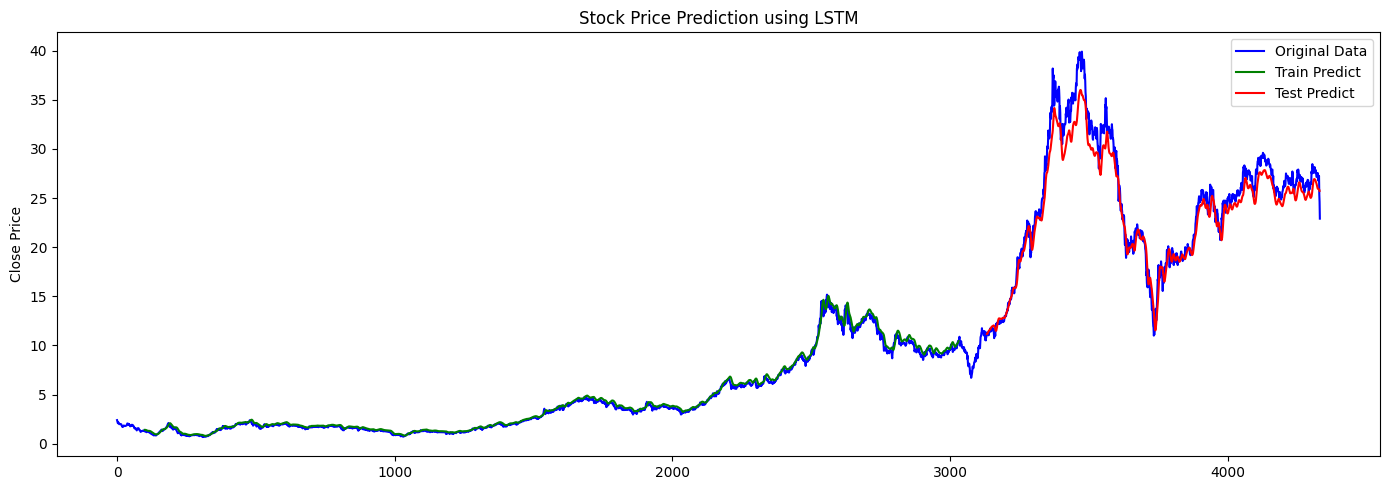

In [36]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
dates = df.index

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.figure(figsize=(14,5))
plt.plot(scaler.inverse_transform(df1), color='b', label='Original Data')
plt.plot(trainPredictPlot, color='g', label='Train Predict')
plt.plot(testPredictPlot, color='r', label='Test Predict')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.tight_layout()
plt.show()